# TAT-C: Collect Observations Example

This example demonstrates how to use direct function calls of the low-level TAT-C library to collect observations of a surface point.

First we define the satellites for a mission. In this example we define one satellite (NOAA-20) with a single instrument (Visual/Infrared Imager Radiometer Suite, VIIRS) and an orbit derived from a known two-line element set (TLE). The TLE defines the orbital state at an instant in time which can be used to determine future positions of the satellite. The example TLE below for NOAA-20 was collected from [CelesTrak](https://celestrak.org/) around July 2022.

TAT-C allows several types of orbit specifications, one of which being the `TwoLineElements` specification which requires the TLE as an argument.

In [1]:
noaa20_tle = [
    "1 43013U 17073A   22195.78278435  .00000038  00000+0  38919-4 0  9996",
    "2 43013  98.7169 133.9110 0001202  63.8768 296.2532 14.19561306241107",
]
from tatc.schemas import TwoLineElements

noaa20_orbit = TwoLineElements(tle=noaa20_tle)

Next, we define an instrument to perform observations. The most important parameter is the _field of regard_ which sets the view angle from the satellite to the Earth's surface. The TAT-C `utils` package contains a function to calculate the field of regard (111.6 degrees) from an instrument's stated swath width (3000 km) and altitude (834 km).

In [2]:
from tatc import utils

viirs_for = utils.swath_width_to_field_of_regard(834000, 3000000)
print(f"computed field of regard: {viirs_for:.1f}")

from tatc.schemas import Instrument

viirs = Instrument(name="VIIRS", field_of_regard=viirs_for)

computed field of regard: 111.6


Finally, we can combine the orbit and instrument to define a new satellite.

In [3]:
from tatc.schemas import Satellite

noaa20 = Satellite(name="NOAA 20", orbit=noaa20_orbit, instruments=[viirs])

Next, we define the point of interest to observe using geodetic coordinates.

In [4]:
from tatc.schemas import Point

hoboken = Point(id=0, latitude=40.74259, longitude=-74.02686)

Next, we can identify the starting and ending time of a sample mission period. The starting time is noon UTC on February 1, 2022 and the ending time is 30 days later (noon UTC on March 3, 2022).

In [5]:
from datetime import datetime, timedelta, timezone

start = datetime(year=2022, month=2, day=1, hour=12, tzinfo=timezone.utc)
end = start + timedelta(days=30)

The `collect_observations` analysis function identifies all of the observation opportunities of a point by a satellite instrument between the starting and ending time. Results are formatted as a flat GeoDataFrame which is similar to a regular pandas DataFrame with a geospatial column labeled `geometry`. Other columns:
 * `start`: observation rise time (or mission start for first observation)
 * `end`: observation set time (or mission end for last observation)
 * `epoch`: observation midpoint
 * `sat_alt`: satellite altitude angle (degrees) at epoch
 * `sat_az`: satellite azimuth angle (degrees) at epoch

In [6]:
from tatc.analysis import collect_observations

results = collect_observations(hoboken, noaa20, viirs, start, end)
display(results)

,point_id,geometry,satellite,instrument,start,end,epoch,sat_alt,sat_az
0,0,POINT (-74.02686 40.74259),NOAA 20,VIIRS,2022-02-01 18:10:20.024332+00:00,2022-02-01 18:17:29.401363+00:00,2022-02-01 18:13:54.712847500+00:00,57.793718,259.656528
1,0,POINT (-74.02686 40.74259),NOAA 20,VIIRS,2022-02-02 06:28:46.792096+00:00,2022-02-02 06:35:58.336406+00:00,2022-02-02 06:32:22.564251+00:00,59.926603,100.686290
2,0,POINT (-74.02686 40.74259),NOAA 20,VIIRS,2022-02-02 17:51:22.457700+00:00,2022-02-02 17:58:51.179708+00:00,2022-02-02 17:55:06.818704+00:00,85.131281,260.540099
3,0,POINT (-74.02686 40.74259),NOAA 20,VIIRS,2022-02-03 06:10:22.574509+00:00,2022-02-03 06:16:41.187744+00:00,2022-02-03 06:13:31.881126500+00:00,40.116598,97.950146
4,0,POINT (-74.02686 40.74259),NOAA 20,VIIRS,2022-02-03 07:51:25.894025+00:00,2022-02-03 07:55:37.607446+00:00,2022-02-03 07:53:31.750735500+00:00,26.706893,294.816029
...,...,...,...,...,...,...,...,...,...
83,0,POINT (-74.02686 40.74259),NOAA 20,VIIRS,2022-03-02 06:04:37.697200+00:00,2022-03-02 06:10:30.186658+00:00,2022-03-02 06:07:33.941929+00:00,35.582880,97.107339
84,0,POINT (-74.02686 40.74259),NOAA 20,VIIRS,2022-03-02 07:45:11.185899+00:00,2022-03-02 07:50:06.257805+00:00,2022-03-02 07:47:38.721852+00:00,29.744383,293.833804
85,0,POINT (-74.02686 40.74259),NOAA 20,VIIRS,2022-03-02 17:26:53.271422+00:00,2022-03-02 17:34:00.635630+00:00,2022-03-02 17:30:26.953526+00:00,58.528071,71.448252
86,0,POINT (-74.02686 40.74259),NOAA 20,VIIRS,2022-03-03 05:46:57.346605+00:00,2022-03-03 05:50:20.904744+00:00,2022-03-03 05:48:39.125674500+00:00,24.233113,94.204459


The `aggregate_observations` function groups observations of points to compute metrics like access and revisit.
 * `access`: duration of an observation
 * `revisit`: duration since the prior observation (note: the first observation has `NaT` for missing data

In [7]:
from tatc.analysis import aggregate_observations

aggregated_results = aggregate_observations(results)
display(aggregated_results)

,point_id,geometry,satellite,instrument,start,epoch,end,access,revisit
0,0,POINT (-74.02686 40.74259),NOAA 20,VIIRS,2022-02-01 18:10:20.024332+00:00,2022-02-01 18:13:54.712847616+00:00,2022-02-01 18:17:29.401363+00:00,0 days 00:07:09.377031,NaT
1,0,POINT (-74.02686 40.74259),NOAA 20,VIIRS,2022-02-02 06:28:46.792096+00:00,2022-02-02 06:32:22.564250880+00:00,2022-02-02 06:35:58.336406+00:00,0 days 00:07:11.544310,0 days 12:11:17.390733
2,0,POINT (-74.02686 40.74259),NOAA 20,VIIRS,2022-02-02 17:51:22.457700+00:00,2022-02-02 17:55:06.818703872+00:00,2022-02-02 17:58:51.179708+00:00,0 days 00:07:28.722008,0 days 11:15:24.121294
3,0,POINT (-74.02686 40.74259),NOAA 20,VIIRS,2022-02-03 06:10:22.574509+00:00,2022-02-03 06:13:31.881126400+00:00,2022-02-03 06:16:41.187744+00:00,0 days 00:06:18.613235,0 days 12:11:31.394801
4,0,POINT (-74.02686 40.74259),NOAA 20,VIIRS,2022-02-03 07:51:25.894025+00:00,2022-02-03 07:53:31.750735616+00:00,2022-02-03 07:55:37.607446+00:00,0 days 00:04:11.713421,0 days 01:34:44.706281
...,...,...,...,...,...,...,...,...,...
83,0,POINT (-74.02686 40.74259),NOAA 20,VIIRS,2022-03-02 06:04:37.697200+00:00,2022-03-02 06:07:33.941928960+00:00,2022-03-02 06:10:30.186658+00:00,0 days 00:05:52.489458,0 days 12:11:42.648733
84,0,POINT (-74.02686 40.74259),NOAA 20,VIIRS,2022-03-02 07:45:11.185899+00:00,2022-03-02 07:47:38.721851904+00:00,2022-03-02 07:50:06.257805+00:00,0 days 00:04:55.071906,0 days 01:34:40.999241
85,0,POINT (-74.02686 40.74259),NOAA 20,VIIRS,2022-03-02 17:26:53.271422+00:00,2022-03-02 17:30:26.953526016+00:00,2022-03-02 17:34:00.635630+00:00,0 days 00:07:07.364208,0 days 09:36:47.013617
86,0,POINT (-74.02686 40.74259),NOAA 20,VIIRS,2022-03-03 05:46:57.346605+00:00,2022-03-03 05:48:39.125674496+00:00,2022-03-03 05:50:20.904744+00:00,0 days 00:03:23.558139,0 days 12:12:56.710975


Finally, TAT-C includes a supplemental method `reduce_observations` to reduce observations to descriptive statistics.

In [8]:
from tatc.analysis import reduce_observations

reduced_results = reduce_observations(aggregated_results)
display(reduced_results)

,point_id,geometry,access,revisit,samples
0,0,POINT (-74.02686 40.74259),0 days 00:05:48.152080,0 days 08:03:20.872709,88


The same sequence of operations can be repeated for satellite constellations using the `collect_multi_observations` function call.

In [9]:
from tatc.schemas import WalkerConstellation

const = WalkerConstellation(
    name="NOAA 20",
    orbit=noaa20_orbit,
    instruments=[viirs],
    number_satellites=3,
    number_planes=3,
    configuration="star",
)

from tatc.analysis import collect_multi_observations

results = collect_multi_observations(hoboken, const, start, end)
display(results)

,point_id,geometry,satellite,instrument,start,end,epoch,sat_alt,sat_az
0,0,POINT (-74.02686 40.74259),NOAA 20 #3,VIIRS,2022-02-01 14:55:49.488639+00:00,2022-02-01 15:03:21.606324+00:00,2022-02-01 14:59:35.547481500+00:00,84.892227,286.775708
1,0,POINT (-74.02686 40.74259),NOAA 20 #1,VIIRS,2022-02-01 17:51:23.463609+00:00,2022-02-01 17:58:56.323755+00:00,2022-02-01 17:55:09.893682+00:00,88.543514,60.338114
2,0,POINT (-74.02686 40.74259),NOAA 20 #2,VIIRS,2022-02-01 21:15:30.048198+00:00,2022-02-01 21:21:59.730977+00:00,2022-02-01 21:18:44.889587500+00:00,42.291948,69.128044
3,0,POINT (-74.02686 40.74259),NOAA 20 #2,VIIRS,2022-02-01 22:57:14.957431+00:00,2022-02-01 23:00:55.746134+00:00,2022-02-01 22:59:05.351782500+00:00,24.554531,265.737556
4,0,POINT (-74.02686 40.74259),NOAA 20 #3,VIIRS,2022-02-02 00:41:45.880448+00:00,2022-02-02 00:43:18.516276+00:00,2022-02-02 00:42:32.198362+00:00,21.190547,62.901598
...,...,...,...,...,...,...,...,...,...
257,0,POINT (-74.02686 40.74259),NOAA 20 #1,VIIRS,2022-03-02 18:49:42.068410+00:00,2022-03-02 18:54:27.659015+00:00,2022-03-02 18:52:04.863712500+00:00,28.159099,264.705126
258,0,POINT (-74.02686 40.74259),NOAA 20 #2,VIIRS,2022-03-02 22:11:43.752490+00:00,2022-03-02 22:19:00.730607+00:00,2022-03-02 22:15:22.241548500+00:00,60.682313,259.360646
259,0,POINT (-74.02686 40.74259),NOAA 20 #3,VIIRS,2022-03-03 01:35:11.920068+00:00,2022-03-03 01:42:31.027041+00:00,2022-03-03 01:38:51.473554500+00:00,64.260675,71.416147
260,0,POINT (-74.02686 40.74259),NOAA 20 #1,VIIRS,2022-03-03 07:06:40.376224+00:00,2022-03-03 07:14:03.382109+00:00,2022-03-03 07:10:21.879166500+00:00,68.225458,287.450749


In [10]:
aggregated_results = aggregate_observations(results)
display(aggregated_results)

,point_id,geometry,satellite,instrument,start,epoch,end,access,revisit
0,0,POINT (-74.02686 40.74259),NOAA 20 #3,VIIRS,2022-02-01 14:55:49.488639+00:00,2022-02-01 14:59:35.547481600+00:00,2022-02-01 15:03:21.606324+00:00,0 days 00:07:32.117685,NaT
1,0,POINT (-74.02686 40.74259),NOAA 20 #1,VIIRS,2022-02-01 17:51:23.463609+00:00,2022-02-01 17:55:09.893681920+00:00,2022-02-01 17:58:56.323755+00:00,0 days 00:07:32.860146,0 days 02:48:01.857285
2,0,POINT (-74.02686 40.74259),NOAA 20 #2,VIIRS,2022-02-01 21:15:30.048198+00:00,2022-02-01 21:18:44.889587456+00:00,2022-02-01 21:21:59.730977+00:00,0 days 00:06:29.682779,0 days 03:16:33.724443
3,0,POINT (-74.02686 40.74259),NOAA 20 #2,VIIRS,2022-02-01 22:57:14.957431+00:00,2022-02-01 22:59:05.351782400+00:00,2022-02-01 23:00:55.746134+00:00,0 days 00:03:40.788703,0 days 01:35:15.226454
4,0,POINT (-74.02686 40.74259),NOAA 20 #3,VIIRS,2022-02-02 00:41:45.880448+00:00,2022-02-02 00:42:32.198362112+00:00,2022-02-02 00:43:18.516276+00:00,0 days 00:01:32.635828,0 days 01:40:50.134314
...,...,...,...,...,...,...,...,...,...
257,0,POINT (-74.02686 40.74259),NOAA 20 #1,VIIRS,2022-03-02 18:49:42.068410+00:00,2022-03-02 18:52:04.863712512+00:00,2022-03-02 18:54:27.659015+00:00,0 days 00:04:45.590605,0 days 01:34:50.731676
258,0,POINT (-74.02686 40.74259),NOAA 20 #2,VIIRS,2022-03-02 22:11:43.752490+00:00,2022-03-02 22:15:22.241548544+00:00,2022-03-02 22:19:00.730607+00:00,0 days 00:07:16.978117,0 days 03:17:16.093475
259,0,POINT (-74.02686 40.74259),NOAA 20 #3,VIIRS,2022-03-03 01:35:11.920068+00:00,2022-03-03 01:38:51.473554432+00:00,2022-03-03 01:42:31.027041+00:00,0 days 00:07:19.106973,0 days 03:16:11.189461
260,0,POINT (-74.02686 40.74259),NOAA 20 #1,VIIRS,2022-03-03 07:06:40.376224+00:00,2022-03-03 07:10:21.879166464+00:00,2022-03-03 07:14:03.382109+00:00,0 days 00:07:23.005885,0 days 05:24:09.349183


In [11]:
reduced_results = reduce_observations(aggregated_results)
display(reduced_results)

,point_id,geometry,access,revisit,samples
0,0,POINT (-74.02686 40.74259),0 days 00:05:57.115326,0 days 02:38:33.148549,262


Enabling quick sensitivity analyses.

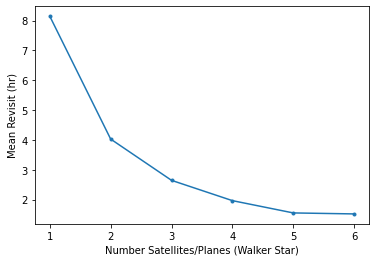

In [13]:
import numpy as np
n = np.arange(1,7)
revisit = [
    reduce_observations(
        aggregate_observations(
            collect_multi_observations(
                hoboken,
                WalkerConstellation(
                    name="NOAA 20",
                    orbit=noaa20_orbit,
                    instruments=[viirs],
                    number_satellites=i,
                    number_planes=i,
                    configuration="star",
                ),
                start,
                end,
            )
        )
    )
    .iloc[0]
    .revisit
    / timedelta(hours=1)
    for i in n
]

import matplotlib.pyplot as plt
plt.figure()
plt.plot(n, revisit, ".-")
plt.xlabel("Number Satellites/Planes (Walker Star)")
plt.ylabel("Mean Revisit (hr)")
plt.show()